# Deep Hedging
### In this notebook, we study the influence of transaction costs on the pricing and hedging of europeaun options, via Deep Hedging
### - We study a few networks
### - the exponential utility function
### - the impact on prices (writer AND buyer)
### - the trade frequency and average shares traded
### - the shape of the no transaction bands
### - the impact on callspread pricing and hedging

# Packages

In [1]:
#!pip install pfhedge
!pip install -r ../../requirements.txt


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as fn
from torch import Tensor
from torch.nn import Module
import matplotlib.pyplot as plt
from math import log, sqrt
from torch.distributions.normal import Normal


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/julesarzel/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/julesarzel/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/julesarzel/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io

In [2]:
from pfhedge.instruments import BrownianStock
from pfhedge.instruments import EuropeanOption
from pfhedge.nn import BlackScholes
from pfhedge.nn import Clamp
from pfhedge.nn import Hedger
from pfhedge.nn import MultiLayerPerceptron
from pfhedge.nn import EntropicRiskMeasure
from pfhedge.nn import Hedger
from pfhedge.instruments import BaseDerivative
from pfhedge.features import LogMoneyness, TimeToMaturity, Volatility, PrevHedge

In [3]:
from networks import MultiLayerPerceptron, NoTransactionBandNet, TwoHeadHedgeNet

# Option characteristics

In [ ]:
stock = BrownianStock(cost=1e-4, dt=1/250)
derivative = EuropeanOption(stock, maturity=1)
gamma = 1.0
tc = 1e-4

train = False

derivative

EuropeanOption(
  strike=1., maturity=1
  (underlier): BrownianStock(sigma=0.2000, cost=1.0000e-04, dt=0.0040)
)

# Training and Pricing with the MLP

In [ ]:
# EXAMPLE

'''torch.manual_seed(42)

# Prepare a derivative to hedge
derivative = EuropeanOption(BrownianStock(cost=1e-4), maturity=1)

# Create your hedger
model_MLP = MultiLayerPerceptron()
hedger_MLP = Hedger(model_MLP, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])

# Fit and price
hedger_MLP.fit(derivative, n_paths=10000, n_epochs=200)
price_MLP = hedger_MLP.price(derivative, n_paths=10000)
print(f"Price={price_MLP:.5e}")'''

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Loss=0.0467: 100%|██████████| 200/200 [09:54<00:00,  2.97s/it]


Price=5.05762e-02


# Training and Pricing with the NTBN

In [7]:
#EXAMPLE 

'''torch.manual_seed(42)

# Prepare a derivative to hedge
derivative = EuropeanOption(BrownianStock(cost=1e-4), maturity=1)

# Create your hedger
model_NTBN = NoTransactionBandNet(derivative)
hedger_NTBN = Hedger(model_NTBN, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])

# Fit and price
hedger_NTBN.fit(derivative, n_paths=10000, n_epochs=200)
price_NTBN = hedger_NTBN.price(derivative, n_paths=10000)
print(f"Price={price_NTBN:.5e}")'''

'torch.manual_seed(42)\n\n# Prepare a derivative to hedge\nderivative = EuropeanOption(BrownianStock(cost=1e-4), maturity=1)\n\n# Create your hedger\nmodel_NTBN = NoTransactionBandNet(derivative)\nhedger_NTBN = Hedger(model_NTBN, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])\n\n# Fit and price\nhedger_NTBN.fit(derivative, n_paths=10000, n_epochs=200)\nprice_NTBN = hedger_NTBN.price(derivative, n_paths=10000)\nprint(f"Price={price_NTBN:.5e}")'

# To train and price with a different initial stock price

In [ ]:
# EXAMPLE

'''S0 = 100.0

derivative = EuropeanOption(BrownianStock(cost=tc, dt=1/250), strike=100, maturity=1.0)

model = MultiLayerPerceptron()
hedger = Hedger(
    model,
    ["log_moneyness", "expiry_time", "volatility", "prev_hedge"],
)

hedger.fit(
    derivative,
    n_paths=10000,
    n_epochs=200,
    init_state=(S0,)  
)

price = hedger.price(
    derivative,
    n_paths=10000,
    init_state=(S0,)
)

print(f"Option price with S0 = {S0}: {price:.5f}")
'''

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loss=11.9308: 100%|██████████| 200/200 [09:29<00:00,  2.85s/it]


Option price with S0 = 100.0: 11.94569


# Training of both networks for several different cost levels 

In [ ]:
train = False

### Transaction costs levels

In [ ]:
for i in range(11):
    print(f'exp de {-i}={np.exp(-i)}')

exp de 0=1.0
exp de -1=0.36787944117144233
exp de -2=0.1353352832366127
exp de -3=0.049787068367863944
exp de -4=0.01831563888873418
exp de -5=0.006737946999085467
exp de -6=0.0024787521766663585
exp de -7=0.0009118819655545162
exp de -8=0.00033546262790251185
exp de -9=0.00012340980408667956
exp de -10=4.5399929762484854e-05


In [ ]:
tc = [np.exp(-i) for i in range(1,11)]

### Training of models for different tc levels

In [ ]:
if train :
    for i in range(len(tc)):
        globals()[f'derivative_{i}'] = EuropeanOption(BrownianStock(cost=tc[i]), maturity=1)
        globals()[f'model_MLP_{i}'] = MultiLayerPerceptron()
        globals()[f'model_NTBN_{i}'] = NoTransactionBandNet(globals()[f'derivative_{i}'])
        globals()[f'hedger_MLP_{i}'] = Hedger(globals()[f'model_MLP_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
        globals()[f'hedger_NTBN_{i}'] = Hedger(globals()[f'model_NTBN_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
        globals()[f'hedger_MLP_{i}'].fit(globals()[f'derivative_{i}'], n_paths=10000, n_epochs=100)
        globals()[f'hedger_NTBN_{i}'].fit(globals()[f'derivative_{i}'], n_paths=10000, n_epochs=100)
        globals()[f'price_MLP_{i}'] = globals()[f'hedger_MLP_{i}'].price(globals()[f'derivative_{i}'], n_paths=10000)
        globals()[f'price_NTBN_{i}'] = globals()[f'hedger_NTBN_{i}'].price(globals()[f'derivative_{i}'], n_paths=10000)
        
        torch.save(globals()[f'hedger_MLP_{i}'].state_dict(), f"MLP_{i}.pth")
        torch.save(globals()[f'hedger_NTBN_{i}'].state_dict(), f"NTBN_{i}.pth")

In [7]:
if train:    
    derivative_0 = EuropeanOption(BrownianStock(cost=0), maturity=1)
    model_MLP_0 = MultiLayerPerceptron()
    hedger_MLP_0 = Hedger(model_MLP_0, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
    hedger_MLP_0.fit(derivative_0, n_paths=10000, n_epochs=100)
    model_NTBN_0 = NoTransactionBandNet(derivative_0)
    hedger_NTBN_0 = Hedger(model_NTBN_0, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
    hedger_NTBN_0.fit(derivative_0, n_paths=10000, n_epochs=100)

    torch.save(hedger_MLP_0.state_dict(), "MLP_0.pth")
    torch.save(hedger_NTBN_0.state_dict(), "NTBN_0.pth")

### Loading of the model if they already have been trained and saved 

In [ ]:
load = True

In [ ]:
if load : 
    for i in range(2,11):
        globals()[f'derivative_{i}'] = EuropeanOption(BrownianStock(cost=np.exp(-i)), maturity=1)
        globals()[f'model_MLP_{i}'] = MultiLayerPerceptron()
        globals()[f'model_NTBN_{i}'] = NoTransactionBandNet(globals()[f'derivative_{i}'])
        globals()[f'hedger_MLP_{i}'] = Hedger(globals()[f'model_MLP_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
        globals()[f'hedger_NTBN_{i}'] = Hedger(globals()[f'model_NTBN_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
        globals()[f'hedger_MLP_{i}'].load_state_dict(torch.load(f'models/MLP_{i}.pth'))
        globals()[f'hedger_NTBN_{i}'].load_state_dict(torch.load(f'models/NTBN_{i}.pth'))
    
if load : 
    derivative_0 = EuropeanOption(BrownianStock(cost=0), maturity=1)
    model_MLP_0 = MultiLayerPerceptron()
    hedger_MLP_0 = Hedger(model_MLP_0, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
    model_NTBN_0 = NoTransactionBandNet(derivative_0)
    hedger_NTBN_0 = Hedger(model_NTBN_0, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
    hedger_MLP_0.load_state_dict(torch.load('models/MLP_0.pth'))
    hedger_NTBN_0.load_state_dict(torch.load('models/NTBN_0.pth'))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

### Pricing once models are loaded

In [ ]:
price_MLP = []
price_NTBN = []
for i in range(3,10):
    globals()[f'hedger_MLP_{i}'].eval()
    globals()[f'hedger_NTBN_{i}'].eval()
    price_MLP.append(eval(f'hedger_MLP_{i}').price(derivative, n_paths=10000, n_times = 10).item())
    price_NTBN.append(eval(f'hedger_NTBN_{i}').price(derivative, n_paths=10000, n_times = 10).item())
    print(f'Transaction Costs {i} done')

price_MLP_0 = hedger_MLP_0.price(derivative_0, n_paths=10000, n_times=10).item()
price_NTBN_0 = hedger_NTBN_0.price(derivative_0, n_paths=10000, n_times=10).item()

Transaction Costs 3 done
Transaction Costs 4 done
Transaction Costs 5 done
Transaction Costs 6 done
Transaction Costs 7 done
Transaction Costs 8 done
Transaction Costs 9 done


### Plot of the price spreads 

In [8]:
trans_costs = []
for i in range(-10,-1):
    trans_costs.append(np.exp(i))
    
x_pos = list(range(-10,-1))  

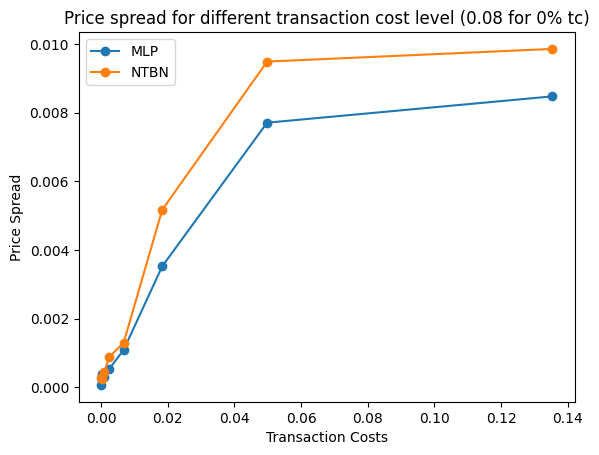

In [21]:
price_spread_MLP = np.array(price_MLP) - price_MLP_0
price_spread_NTBN = np.array(price_NTBN) - price_NTBN_0
plt.plot(trans_costs,price_spread_MLP[::-1], 'o-', label='MLP')
plt.plot(trans_costs,price_spread_NTBN[::-1], 'o-', label='NTBN')
plt.ylabel('Price Spread')
plt.xlabel('Transaction Costs')
plt.title('Price spread for different transaction cost level (0.08 for 0% tc)')
plt.legend()
plt.show()

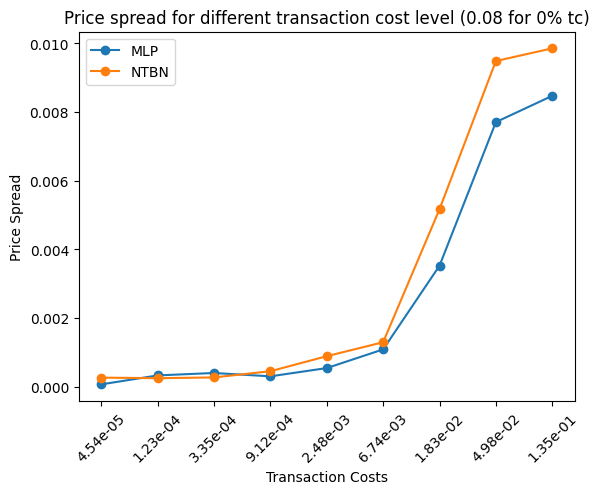

In [22]:
price_spread_MLP = np.array(price_MLP) - price_MLP_0
price_spread_NTBN = np.array(price_NTBN) - price_NTBN_0
plt.plot(x_pos,price_spread_MLP[::-1], 'o-', label='MLP')
plt.plot(x_pos,price_spread_NTBN[::-1], 'o-', label='NTBN')
plt.xticks(x_pos, [f"{val:.2e}" for val in trans_costs], rotation=45)
plt.ylabel('Price Spread')
plt.xlabel('Transaction Costs')
plt.title('Price spread for different transaction cost level (0.08 for 0% tc)')
plt.legend()
plt.show()

### Computation of the expected utility for those transaction costs levels, using pfhedge

In [6]:
utility_MLP = {}
utility_NTBN = {}
for i in range(2,11):
    eval(f'derivative_{i}').simulate(20000)
    wealth_MLP = []
    wealth_NTBN = []
    wealth_MLP = eval(f'hedger_MLP_{i}').compute_pl(eval(f'derivative_{i}'))
    wealth_NTBN = eval(f'hedger_NTBN_{i}').compute_pl(eval(f'derivative_{i}'))
    U_MLP = -torch.exp(-gamma * wealth_MLP)  
    U_NTBN = -torch.exp(-gamma * wealth_NTBN)  
    utility_MLP[i] = U_MLP.mean().item()
    utility_NTBN[i] = U_NTBN.mean().item()
    print(f'transdaction cost {i} done')

transdaction cost 2 done
transdaction cost 3 done
transdaction cost 4 done
transdaction cost 5 done
transdaction cost 6 done
transdaction cost 7 done
transdaction cost 8 done
transdaction cost 9 done
transdaction cost 10 done


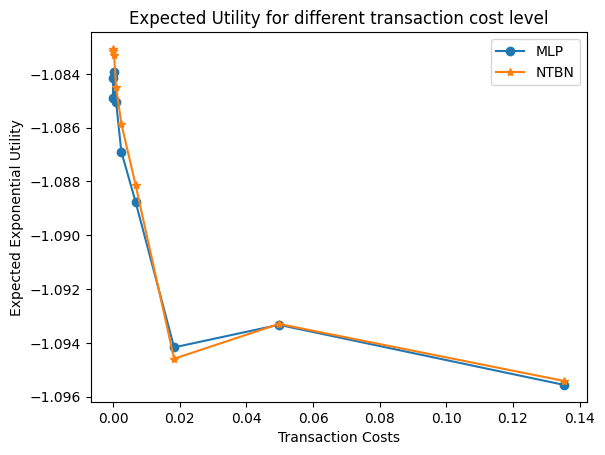

In [9]:
plt.plot(trans_costs,list(utility_MLP.values())[::-1], 'o-', label='MLP')
plt.plot(trans_costs,list(utility_NTBN.values())[::-1], '*-', label='NTBN')
plt.ylabel('Expected Exponential Utility')
plt.xlabel('Transaction Costs')
plt.title('Expected Utility for different transaction cost level')
plt.legend()
plt.show()

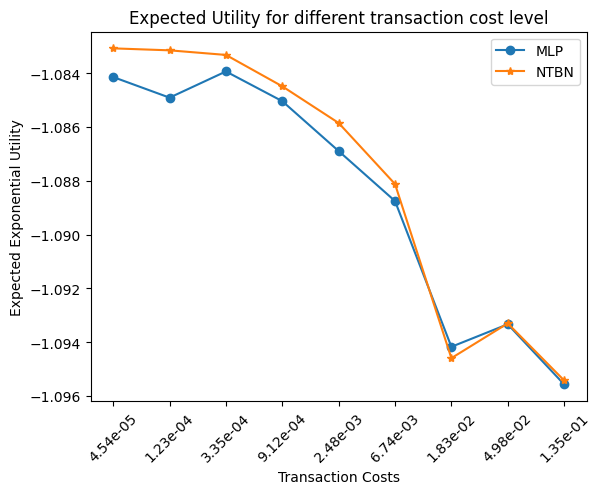

In [10]:
plt.plot(x_pos,list(utility_MLP.values())[::-1], 'o-', label='MLP')
plt.plot(x_pos,list(utility_NTBN.values())[::-1], '*-', label='NTBN')
plt.xticks(x_pos, [f"{val:.2e}" for val in trans_costs], rotation=45)
plt.ylabel('Expected Exponential Utility')
plt.xlabel('Transaction Costs')
plt.title('Expected Utility for different transaction cost level')
plt.legend()
plt.show()


# No Transaction Band for different transaction costs levels

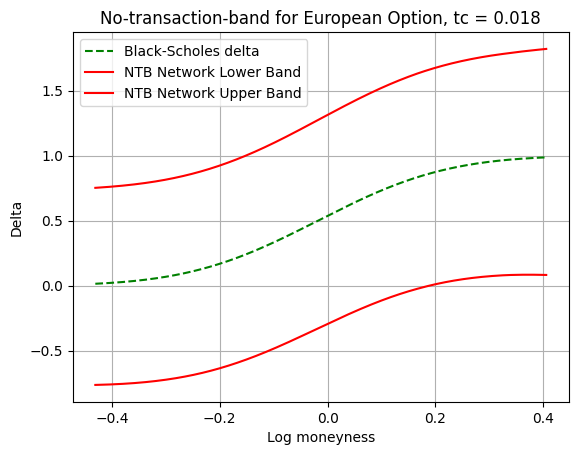

In [ ]:
from functions import notransactionband

# Parameters
S0 = 1
K = 1
T = 1.0
sigma = 0.2
time_slice = 0.1 * T
model = hedger_NTBN_4.model

log_moneyness, delta_vals, lower, upper = notransactionband(K,T,time_slice,sigma,model)

# Plot
plt.plot(log_moneyness.tolist(), delta_vals.tolist(), linestyle='--', color='green', label="Black-Scholes delta")
plt.plot(log_moneyness.tolist(), lower.tolist(), color='red', label="NTB Network Lower Band")
plt.plot(log_moneyness.tolist(), upper.tolist(), color='red', label="NTB Network Upper Band")
plt.xlabel("Log moneyness")
plt.ylabel("Delta")
plt.title(f"No-transaction-band for European Option, tc = {np.exp(-4):.3f}")
plt.legend()
plt.grid(True)
plt.show()



# Trade metrics : Trade frequency and Number of shares traded

In [ ]:
from functions import compute_trade_frequency_pfhedge, compute_avg_num_shares_traded_pfhedge

In [8]:
derivative.simulate(n_paths = 1000)
derivative_2.simulate(n_paths = 1000)
derivative_3.simulate(n_paths = 1000)
derivative_4.simulate(n_paths = 1000)
derivative_5.simulate(n_paths = 1000)
derivative_6.simulate(n_paths = 1000)
derivative_7.simulate(n_paths = 1000)
derivative_8.simulate(n_paths = 1000)
derivative_9.simulate(n_paths = 1000)
derivative_10.simulate(n_paths = 1000)
hedge = hedger_NTBN_0.compute_hedge(derivative)
hedge = hedge.squeeze(1)  # Now shape is (1000, 251)
hedge2 = hedger_NTBN_2.compute_hedge(derivative_2)
hedge2 = hedge2.squeeze(1)  # Now shape is (1000, 251)
hedge3 = hedger_NTBN_3.compute_hedge(derivative_3)
hedge3 = hedge3.squeeze(1)  # Now shape is (1000, 251)
hedge4 = hedger_NTBN_4.compute_hedge(derivative_4)
hedge4 = hedge4.squeeze(1)  # Now shape is (1000, 251)
hedge5 = hedger_NTBN_5.compute_hedge(derivative_5)
hedge5 = hedge5.squeeze(1)  # Now shape is (1000, 251)
hedge6 = hedger_NTBN_6.compute_hedge(derivative_6)
hedge6 = hedge6.squeeze(1)  # Now shape is (1000, 251)
hedge7 = hedger_NTBN_7.compute_hedge(derivative_7)
hedge7 = hedge7.squeeze(1)  # Now shape is (1000, 251)
hedge8 = hedger_NTBN_8.compute_hedge(derivative_8)
hedge8 = hedge8.squeeze(1)  # Now shape is (1000, 251)
hedge9 = hedger_NTBN_9.compute_hedge(derivative_9)
hedge9 = hedge9.squeeze(1)  # Now shape is (1000, 251)
hedge10 = hedger_NTBN_10.compute_hedge(derivative_10)
hedge10 = hedge10.squeeze(1)  # Now shape is (1000, 251)

trade_freq = []
trade_freq.append(compute_trade_frequency_pfhedge(hedge))
avg_shares = []
avg_shares.append(compute_avg_num_shares_traded_pfhedge(hedge))

for i in range(10,1,-1):
    trade_freq.append(compute_trade_frequency_pfhedge(eval(f'hedge{i}')))
    avg_shares.append(compute_avg_num_shares_traded_pfhedge(eval(f'hedge{i}')))
    

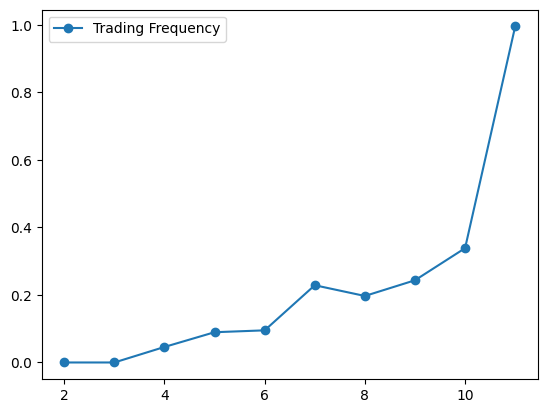

In [24]:
plt.plot(range(11,1,-1),trade_freq, marker='o', label='Trading Frequency')
plt.legend()
plt.show()


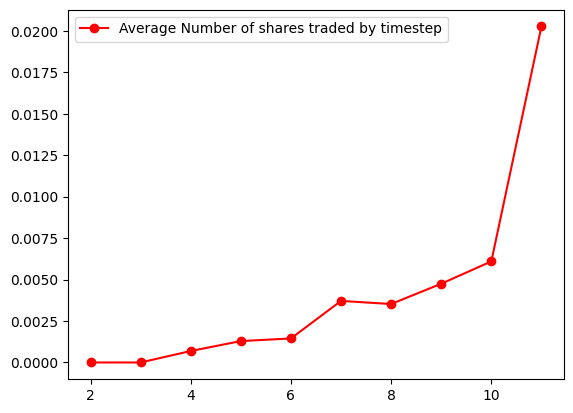

In [25]:
plt.plot(range(11,1,-1),avg_shares, c='red', marker='o', label='Average Number of shares traded by timestep')
plt.legend()
plt.show()

# Call Spread

In [ ]:
from derivatives import NegativeEuropeanOption, CallSpread

## Training of different models for different transaction costs levels

In [11]:
tc = [0, 0.0001, 0.001, 0.01, 0.03]
K1 = 0.9
K2 = 1.1

In [ ]:
train_cs = False

In [31]:
if train_cs:
    for i in tc:
        globals()[f'derivative_K1_{i}'] = EuropeanOption(BrownianStock(cost=i), strike=K1, maturity=1)
        globals()[f'model_MLP_K1_{i}'] = MultiLayerPerceptron()
        globals()[f'hedger_MLP_K1_{i}'] = Hedger(globals()[f'model_MLP_K1_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
        globals()[f'hedger_MLP_K1_{i}'].fit(globals()[f'derivative_K1_{i}'], n_paths=5000, n_epochs=50)
        globals()[f'price_MLP_K1_{i}'] = globals()[f'hedger_MLP_K1_{i}'].price(globals()[f'derivative_K1_{i}'], n_paths=5000)
        
        torch.save(globals()[f'hedger_MLP_K1_{i}'].state_dict(), f"MLP_K1_{i}.pth")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Python(37790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Loss=0.1385: 100%|██████████| 50/50 [02:01<00:00,  2.43s/it]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any mome

In [33]:
if train_cs: 
    for i in tc:
        globals()[f'derivative_K2_{i}'] = NegativeEuropeanOption(BrownianStock(cost=i), strike=K2, maturity=1)
        globals()[f'model_MLP_K2_{i}'] = MultiLayerPerceptron()
        globals()[f'hedger_MLP_K2_{i}'] = Hedger(globals()[f'model_MLP_K2_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
        globals()[f'hedger_MLP_K2_{i}'].fit(globals()[f'derivative_K2_{i}'], n_paths=5000, n_epochs=50)
        globals()[f'price_MLP_K2_{i}'] = globals()[f'hedger_MLP_K2_{i}'].price(globals()[f'derivative_K2_{i}'], n_paths=5000)
        
        torch.save(globals()[f'hedger_MLP_K2_{i}'].state_dict(), f"MLP_K2_{i}.pth")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Loss=-0.0372: 100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


In [ ]:
if train_cs: 
    for i in tc:
        globals()[f'derivative_cs_{i}'] = CallSpread(BrownianStock(cost=i), strike_long=K1, strike_short=K2, maturity=1)
        globals()[f'model_MLP_cs_{i}'] = MultiLayerPerceptron()
        globals()[f'hedger_MLP_cs_{i}'] = Hedger(globals()[f'model_MLP_cs_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
        globals()[f'hedger_MLP_cs_{i}'].fit(globals()[f'derivative_cs_{i}'], n_paths=5000, n_epochs=50)
        globals()[f'price_MLP_cs_{i}'] = globals()[f'hedger_MLP_cs_{i}'].price(globals()[f'derivative_cs_{i}'], n_paths=5000)
        
        torch.save(globals()[f'hedger_MLP_cs_{i}'].state_dict(), f"MLP_cs_{i}.pth")

'if train_cs: \n    for i in tc:\n        globals()[f\'derivative_cs_{i}\'] = CallSpread(BrownianStock(cost=i), strike_long=K1, strike_short=K2, maturity=1)\n        globals()[f\'model_MLP_cs_{i}\'] = MultiLayerPerceptron()\n        globals()[f\'hedger_MLP_cs_{i}\'] = Hedger(globals()[f\'model_MLP_cs_{i}\'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])\n        globals()[f\'hedger_MLP_cs_{i}\'].fit(globals()[f\'derivative_cs_{i}\'], n_paths=5000, n_epochs=50)\n        globals()[f\'price_MLP_cs_{i}\'] = globals()[f\'hedger_MLP_cs_{i}\'].price(globals()[f\'derivative_cs_{i}\'], n_paths=5000)\n\n        torch.save(globals()[f\'hedger_MLP_cs_{i}\'].state_dict(), f"MLP_cs_{i}.pth")'

## Loading of the models if already trained 

In [ ]:
load_cs = True

In [ ]:
if load_cs :
    for i in range(len(tc)):
        globals()[f'derivative_K1_{i}'] = EuropeanOption(BrownianStock(cost=tc[i]), strike=K1, maturity=1)
        globals()[f'model_MLP_K1_{i}'] = MultiLayerPerceptron()
        globals()[f'hedger_MLP_K1_{i}'] = Hedger(globals()[f'model_MLP_K1_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
        globals()[f'hedger_MLP_K1_{i}'].load_state_dict(torch.load(f'models/MLP_K1_{tc[i]}.pth'))

        globals()[f'derivative_K2_{i}'] = NegativeEuropeanOption(BrownianStock(cost=tc[i]), strike=K2, maturity=1)
        globals()[f'model_MLP_K2_{i}'] = MultiLayerPerceptron()
        globals()[f'hedger_MLP_K2_{i}'] = Hedger(globals()[f'model_MLP_K2_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
        globals()[f'hedger_MLP_K2_{i}'].load_state_dict(torch.load(f'models/MLP_K2_{tc[i]}.pth'))

        globals()[f'derivative_cs_{i}'] = CallSpread(BrownianStock(cost=tc[i]), strike_long=K1, strike_short=K2, maturity=1)
        globals()[f'model_MLP_cs_{i}'] = MultiLayerPerceptron()
        globals()[f'hedger_MLP_cs_{i}'] = Hedger(globals()[f'model_MLP_cs_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
        globals()[f'hedger_MLP_cs_{i}'].load_state_dict(torch.load(f'models/MLP_cs_{tc[i]}.pth'))

### Prices Comparison

In [40]:
price_K1 = []
price_K2 = []
price_cs = []

for i in range(len(tc)):
    globals()[f'hedger_MLP_cs_{i}'].eval()
    globals()[f'hedger_MLP_K1_{i}'].eval()
    globals()[f'hedger_MLP_K2_{i}'].eval()
    price_cs.append(eval(f'hedger_MLP_cs_{i}').price(eval(f'derivative_cs_{i}'), n_paths=10000, n_times = 10).item())
    price_K1.append(eval(f'hedger_MLP_K1_{i}').price(eval(f'derivative_K1_{i}'), n_paths=10000, n_times = 10).item())
    price_K2.append(-eval(f'hedger_MLP_K2_{i}').price(eval(f'derivative_K2_{i}'), n_paths=10000, n_times = 10).item())
    
price_K1_K2 = [price_K1[i] - price_K2[i] for i in range(len(price_K1))]


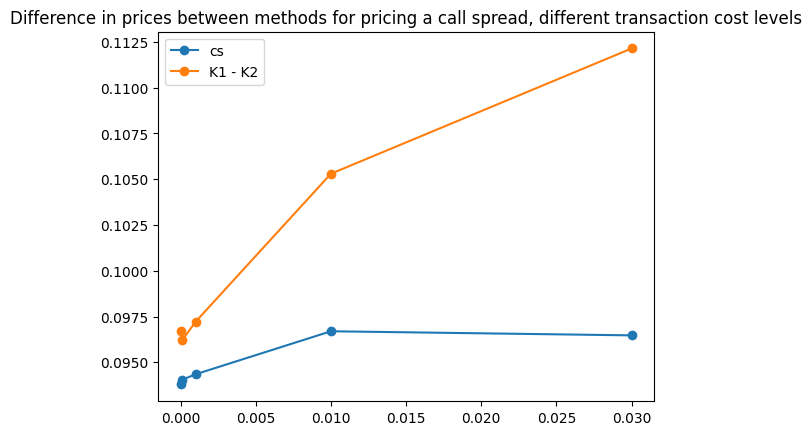

In [42]:
plt.plot(tc, price_cs, marker='o', label='cs')
plt.plot(tc, price_K1_K2, marker='o', label='K1 - K2')
plt.title('Difference in prices between methods for pricing a call spread, different transaction cost levels')
plt.legend()
plt.show()

In [13]:
derivative_K1_0.simulate(n_paths = 10000)
derivative_K2_0.simulate(n_paths = 10000)
derivative_cs_0.simulate(n_paths = 10000)
derivative_K1_1.simulate(n_paths = 10000)
derivative_K2_1.simulate(n_paths = 10000)
derivative_cs_1.simulate(n_paths = 10000)
derivative_K1_2.simulate(n_paths = 10000)
derivative_K2_2.simulate(n_paths = 10000)
derivative_cs_2.simulate(n_paths = 10000)
derivative_K1_3.simulate(n_paths = 10000)
derivative_K2_3.simulate(n_paths = 10000)
derivative_cs_3.simulate(n_paths = 10000)
derivative_K1_4.simulate(n_paths = 10000)
derivative_K2_4.simulate(n_paths = 10000)
derivative_cs_4.simulate(n_paths = 10000)
hedge_K1_0 = hedger_MLP_K1_0.compute_hedge(derivative_K1_0)
hedge_K1_0 = hedge_K1_0.squeeze(1)  # Now shape is (1000, 251)
hedge_K2_0 = hedger_MLP_K2_0.compute_hedge(derivative_K2_0)
hedge_K2_0 = hedge_K2_0.squeeze(1)  # Now shape is (1000, 251)
hedge_cs_0 = hedger_MLP_cs_0.compute_hedge(derivative_cs_0)
hedge_cs_0 = hedge_cs_0.squeeze(1)  # Now shape is (1000, 251)
hedge_K1_1 = hedger_MLP_K1_1.compute_hedge(derivative_K1_1)
hedge_K1_1 = hedge_K1_1.squeeze(1)  # Now shape is (1000, 251)
hedge_K2_1 = hedger_MLP_K2_1.compute_hedge(derivative_K2_1)
hedge_K2_1 = hedge_K2_1.squeeze(1)  # Now shape is (1000, 251)
hedge_cs_1 = hedger_MLP_cs_1.compute_hedge(derivative_cs_1)
hedge_cs_1 = hedge_cs_1.squeeze(1)  # Now shape is (1000, 251)
hedge_K1_2 = hedger_MLP_K1_2.compute_hedge(derivative_K1_2)
hedge_K1_2 = hedge_K1_2.squeeze(1)  # Now shape is (1000, 251)
hedge_K2_2 = hedger_MLP_K2_2.compute_hedge(derivative_K2_2)
hedge_K2_2 = hedge_K2_2.squeeze(1)  # Now shape is (1000, 251)
hedge_cs_2 = hedger_MLP_cs_2.compute_hedge(derivative_cs_2)
hedge_cs_2 = hedge_cs_2.squeeze(1)  # Now shape is (1000, 251)
hedge_K1_3 = hedger_MLP_K1_3.compute_hedge(derivative_K1_3)
hedge_K1_3 = hedge_K1_3.squeeze(1)  # Now shape is (1000, 251)
hedge_K2_3 = hedger_MLP_K2_3.compute_hedge(derivative_K2_3)
hedge_K2_3 = hedge_K2_3.squeeze(1)  # Now shape is (1000, 251)
hedge_cs_3 = hedger_MLP_cs_3.compute_hedge(derivative_cs_3)
hedge_cs_3 = hedge_cs_3.squeeze(1)  # Now shape is (1000, 251)
hedge_K1_4 = hedger_MLP_K1_4.compute_hedge(derivative_K1_4)
hedge_K1_4 = hedge_K1_4.squeeze(1)  # Now shape is (1000, 251)
hedge_K2_4 = hedger_MLP_K2_4.compute_hedge(derivative_K2_4)
hedge_K2_4 = hedge_K2_4.squeeze(1)  # Now shape is (1000, 251)
hedge_cs_4 = hedger_MLP_cs_4.compute_hedge(derivative_cs_4)
hedge_cs_4 = hedge_cs_4.squeeze(1)  # Now shape is (1000, 251)

trade_freq_K1 = []
trade_freq_K2 = []
trade_freq_cs = []
avg_shares_K1 = []
avg_shares_K2 = []
avg_shares_cs = []
trade_freq_combined = []
avg_shares_combined = []

for i in range(5):
    hedge_K1 = eval(f"hedge_K1_{i}")
    hedge_K2 = eval(f"hedge_K2_{i}")
    hedge_cs = eval(f"hedge_cs_{i}")

    # Combined strategy = long call - short call
    hedge_combined = hedge_K1 - hedge_K2

    # Store metrics
    trade_freq_K1.append(compute_trade_frequency_pfhedge(hedge_K1))
    avg_shares_K1.append(compute_avg_num_shares_traded_pfhedge(hedge_K1))

    trade_freq_K2.append(compute_trade_frequency_pfhedge(hedge_K2))
    avg_shares_K2.append(compute_avg_num_shares_traded_pfhedge(hedge_K2))

    trade_freq_cs.append(compute_trade_frequency_pfhedge(hedge_cs))
    avg_shares_cs.append(compute_avg_num_shares_traded_pfhedge(hedge_cs))

    trade_freq_combined.append(compute_trade_frequency_pfhedge(hedge_combined))
    avg_shares_combined.append(compute_avg_num_shares_traded_pfhedge(hedge_combined))




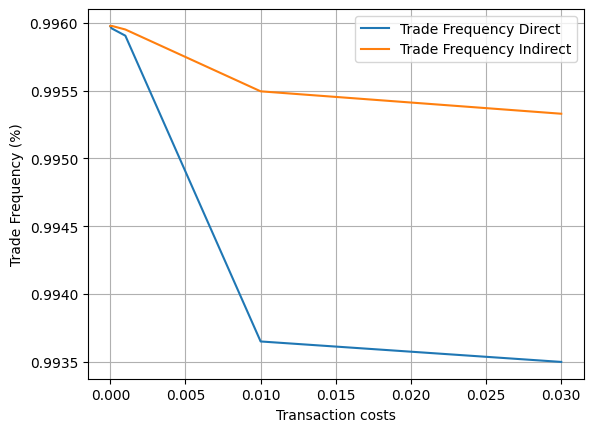

In [18]:
plt.plot(tc, trade_freq_cs, label='Trade Frequency Direct')
plt.plot(tc, trade_freq_combined, label='Trade Frequency Indirect')
plt.xlabel("Transaction costs")
plt.ylabel("Trade Frequency (%)")
plt.grid(True)
plt.legend()
plt.show()

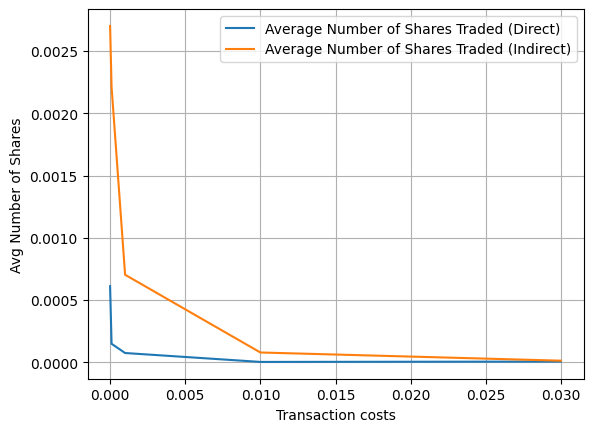

In [14]:
plt.plot(tc, avg_shares_cs, label='Average Number of Shares Traded (Direct)')
plt.plot(tc, avg_shares_combined, label='Average Number of Shares Traded (Indirect)')
plt.xlabel("Transaction costs")
plt.ylabel("Avg Number of Shares")
plt.grid(True)
plt.legend()
plt.show()

# Buyer/Writer prices

In [ ]:
stock = BrownianStock(cost=1e-2)  
maturity = 1.0
gamma = 1.0 

'print(f"Writer Price (Ask):   {price_writer:.5f}")\nprint(f"Buyer Price  (Bid):   {price_buyer:.5f}")\nprint(f"Bid-Ask Spread:       {price_writer - price_buyer:.5f}")'

In [12]:
train_buyer = True

In [ ]:
price_buyer = {}

if train_buyer :
    tc_buyer = [0,np.exp(-9),np.exp(-8),np.exp(-7),np.exp(-6),np.exp(-5),np.exp(-4),np.exp(-3)]
    for i in range(len(tc_buyer)):
        print(tc_buyer[i])
        globals()[f'buyer_derivative_{i}'] = NegativeEuropeanOption(BrownianStock(cost=tc_buyer[i]), maturity=1)
        globals()[f'model_MLP_buyer_{i}'] = MultiLayerPerceptron()
        globals()[f'hedger_MLP_buyer_{i}'] = Hedger(globals()[f'model_MLP_buyer_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
        globals()[f'hedger_MLP_buyer_{i}'].fit(globals()[f'buyer_derivative_{i}'], n_paths=10000, n_epochs=50)
        globals()[f'price_MLP_buyer_{i}'] = -globals()[f'hedger_MLP_buyer_{i}'].price(globals()[f'buyer_derivative_{i}'], n_paths=10000)
        
        price_buyer[tc_buyer[i]]=globals()[f'price_MLP_buyer_{i}'].item()
        
        torch.save(globals()[f'hedger_MLP_buyer_{i}'].state_dict(), f"MLP_buyer_{i}.pth")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


0


Loss=-0.0772: 100%|██████████| 50/50 [02:11<00:00,  2.63s/it]


0.00012340980408667956


Loss=-0.0779: 100%|██████████| 50/50 [02:14<00:00,  2.69s/it]


0.00033546262790251185


Loss=-0.0780: 100%|██████████| 50/50 [02:12<00:00,  2.66s/it]


0.0009118819655545162


Loss=-0.0769: 100%|██████████| 50/50 [02:12<00:00,  2.65s/it]


0.0024787521766663585


Loss=-0.0772: 100%|██████████| 50/50 [02:15<00:00,  2.72s/it]


0.006737946999085467


Loss=-0.0755: 100%|██████████| 50/50 [02:12<00:00,  2.65s/it]


0.01831563888873418


Loss=-0.0710: 100%|██████████| 50/50 [02:21<00:00,  2.83s/it]


0.049787068367863944


Loss=-0.0722: 100%|██████████| 50/50 [02:07<00:00,  2.54s/it]


In [21]:
liste = list(price_buyer.values())
price_buy = [-x for x in liste]

In [27]:
price_MLP.append(price_MLP_0)

In [28]:
price_writer = price_MLP[::-1]

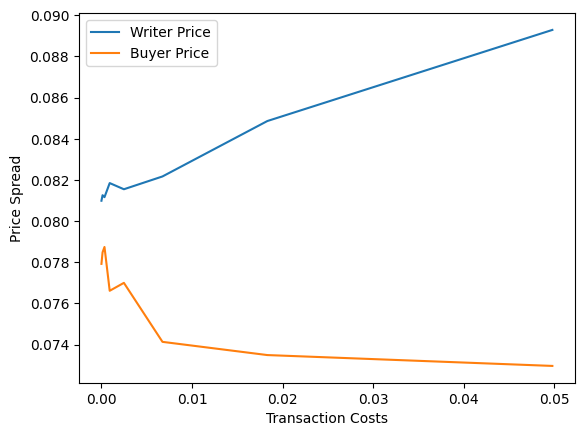

In [29]:
plt.plot(tc_buyer,price_writer,label='Writer Price')
plt.plot(tc_buyer,price_buy,label='Buyer Price')
plt.xlabel('Transaction Costs')
plt.ylabel('Price Spread')
plt.legend()
plt.show()

# New Network : Training for both hedging and pricing

In [ ]:
from functions import crra_utility, exp_utility, compute_pnl, fit_step_by_step

In [49]:
derivative = EuropeanOption(BrownianStock(cost=1e-2), maturity=1.0)
derivative.simulate(n_paths=2000)
derivative.underlier.spot

tensor([[1.0000, 0.9903, 0.9851,  ..., 1.1269, 1.1292, 1.1355],
        [1.0000, 0.9992, 1.0164,  ..., 1.1121, 1.1205, 1.1161],
        [1.0000, 0.9793, 0.9705,  ..., 0.7515, 0.7490, 0.7686],
        ...,
        [1.0000, 1.0119, 1.0140,  ..., 1.2599, 1.2425, 1.2389],
        [1.0000, 1.0223, 1.0279,  ..., 0.9538, 0.9427, 0.9443],
        [1.0000, 1.0199, 1.0204,  ..., 0.9119, 0.9294, 0.9218]])

In [ ]:
model = TwoHeadHedgeNet()
derivative = EuropeanOption(BrownianStock(cost=1e-4), maturity=1.0)

final_price = fit_step_by_step(
    model=model,
    derivative=derivative,
    compute_pnl=compute_pnl,
    utility_fn=exp_utility,
    n_paths=2048,
    n_epochs=200,
    cost=1e-4,
    gamma=0.5,
    lambda_duality=10.0,
    lr=1e-3,
)

print(f"\nFinal learned indifference price: {final_price:.5f}")


[  0] Loss=1.1955 | Price=0.01100 | Duality Gap=0.01605
[ 10] Loss=1.0042 | Price=0.02068 | Duality Gap=0.00230
[ 20] Loss=0.9373 | Price=0.02866 | Duality Gap=0.00026
[ 30] Loss=0.9240 | Price=0.03342 | Duality Gap=0.00262
[ 40] Loss=0.8947 | Price=0.03538 | Duality Gap=0.00194
[ 50] Loss=0.8571 | Price=0.03682 | Duality Gap=0.00081
[ 60] Loss=0.7876 | Price=0.03898 | Duality Gap=0.00070
[ 70] Loss=0.6273 | Price=0.04130 | Duality Gap=0.00132
[ 80] Loss=0.1433 | Price=0.04299 | Duality Gap=0.00046
[ 90] Loss=0.0879 | Price=0.04407 | Duality Gap=0.00024
[100] Loss=0.1617 | Price=0.04473 | Duality Gap=0.00044
[110] Loss=0.1560 | Price=0.04533 | Duality Gap=0.00044
[120] Loss=0.1247 | Price=0.04589 | Duality Gap=0.00038
[130] Loss=0.0826 | Price=0.04636 | Duality Gap=0.00025
[140] Loss=0.0401 | Price=0.04673 | Duality Gap=0.00011
[150] Loss=0.0128 | Price=0.04698 | Duality Gap=0.00002
[160] Loss=0.0013 | Price=0.04710 | Duality Gap=0.00000
[170] Loss=0.0000 | Price=0.04715 | Duality Gap=

# LSTM

In [4]:
from networks import LSTMHedger

In [7]:
torch.manual_seed(42)

# Prepare a derivative to hedge
derivative = EuropeanOption(BrownianStock(cost=1e-4), maturity=1)

# Create your hedger
model = LSTMHedger(4)
hedger = Hedger(model, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])

# Fit and price
hedger.fit(derivative, n_paths=10000, n_epochs=20)
price = hedger.price(derivative, n_paths=10000)
print(f"Price={price:.5e}")

  0%|          | 0/20 [00:00<?, ?it/s]

Loss=0.0881: 100%|██████████| 20/20 [06:12<00:00, 18.62s/it]


Price=8.88796e-02
